## Take Home Assignment

Student ID: 

Collaborators: 919755, 1153929, 1152810, 1151277, 1151248

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

from numpy.linalg import det, inv
from numpy.linalg import matrix_power as mp

from collections import Counter
import os

In [2]:
# Create Subfolders for storage of graphs and tables
if not os.path.exists('Graphs/'):
    os.makedirs('Graphs/')
if not os.path.exists('Tables/'):
    os.makedirs('Tables/')

In [42]:
def Z_matrix(y: np.array, p: int, c: int):
    """Calculate the Z-matrix for a given input

    Args:
        y (np.array): input with all the data of shape (T + p) × K
        p (int): lags
        c (int): intercept yes=1, no=0

    Returns:
        (np.array): Z-matrix for given input
    """

    y = y.T

    #determine matrix dimensions:
    T = y.shape[1] - p
    K = y.shape[0]

    # build Z-matrix
    if c==1:
        Z = np.ones((1, T+p), dtype=float)

    # 1b stacked lagged data
    for i in range(p):
        #add i columns of leading zeros (EDIT: empty, comp cost lower) to ktpmat
        zeros = np.zeros((K, i), dtype=float)
        zerostack = np.hstack((zeros, y[:,:(T+p-i)]))
        # vertically stack this to Z
        Z = np.vstack((Z, zerostack))

    # cutting of leading p columns and retrieving Z
    Z = Z[:, p-1:-1]

    return Z

In [43]:
def B_matrix(y: np.array, p: int, c: int):
    """Calculates the B matrix with the estimated coefficients

    Args:
        y (np.array): input with all the data of shape (T + p) × K
        p (int): lags
        c (int): intercept yes=1, no=0

    Returns:
        _type_: B = matrix with estimated coefficients; Z=Z-matrix; sigma_u=covariance matrix
    """

    # get Z-matrix from function above
    Z = Z_matrix(y, p, c)

    y = y.T # transpose y
    y = y[:,p:] # first p observations are lost as we need prior lags for estimation
    K = y.shape[0] # number of variables
    T = y.shape[1] # number of observations

    # calculate B
    B = y @ Z.T @ np.linalg.inv((Z@Z.T))

    # calculate sigma_u (covariance matrix)
    sigma_u = (1/(T-K*p-1))*(y-(B@Z))@(y-(B@Z)).T

    return B, Z, sigma_u

## Exercise 1

Exercise 1(a-d)

In [44]:
def var1sim(A1: np.array, sigma_u: np.array, T: int):
    """A function that simulates time series data from a K-dimensional VAR(1) process yt = A1 y_t−1 + u_t, 
    where the innovations u_t are drawn from a multivariate normal distribution with mean zero and covariance matrix Σ_u. 
    Uses y_0 = 0 as starting value, where 0 is a K × 1 vector of zeros.
    Generates time series of length T+50 and discards the first 50 observations, 
    such that it returns a time series of total length equal to T.

    Args:
        A1 (np.array): coefficient matrix at lag 1
        sigma_u (np.array): covariance matrix Σ_u
        T (int): number of observations

    Returns:
        np.array: T x K matrix of observations on y_t
    """
    
    K = sigma_u.shape[0]

    # set starting values
    y_tminus1 = np.zeros((K, 1))

    P = np.linalg.cholesky(sigma_u)

    for i in range(T+50):
        # draw disturbance u_t
        u_t = P @ np.random.standard_normal(K)
        u_t = u_t.reshape(K, 1)
        #recursively calculate y_t 
        y_t = A1@y_tminus1 + u_t
        if i == 0:
            y = y_t
        else:
            y = np.hstack((y, y_t))
        y_tminus1 = y_t

    # discard first 50 observations
    y = y[:,50:]

    return y.T

In [45]:
#shouldnt we return T-4 only and not T? Why discard first 50 observations?

In [46]:
def var_information_criteria(y_t: np.array, p_max: int):
    """A function to calculate the 4 information criteria (FPE, AIC, HQ, SC) for a VAR process with maxlag = pmax.
       Assumes model has an intercept and at least one lag. Returns the chosen lag order.

    Args:
        y_t (np.array): K x (T + p_max) matrix of observations on y_t
        p_max (int): maximum number of lags included in the model

    Returns:
        np.array: lags chosen for FPE, AIC, SC and HQ
    """
    
    # arrays to store IC values
    FPE, AIC, HQ, SC = np.zeros(p_max), np.zeros(p_max), np.zeros(p_max), np.zeros(p_max)

    # get T and K from the shape of the input
    K = y_t.shape[0]
    T = y_t.shape[1] - p_max # lags needed for estimation
    
    # calculate information criteria for lags m
    for m in range(1, p_max+1):
        
        # estimate sigma_u_tilde with MLE (2.55 - 2.56)
        Z = Z_matrix(y_t[:, p_max-m:].T,  m, c=1) # take m lags for estimation
        B_tilde = y_t[:, p_max:] @ Z.T @ inv(Z@Z.T)
        sigma_tilde_m = (1/T)*(y_t[:, p_max:] - B_tilde@Z)@(y_t[:, p_max:] - B_tilde@Z).T
        
        # calculate ICs for given lag m (2.107 - 2.114)
        det_sigma_tilde_m = det(sigma_tilde_m)
        FPE[m-1] = (((T + K*m + 1) / (T - K*m - 1)) ** K) * det_sigma_tilde_m
        AIC[m-1] = np.log(det_sigma_tilde_m) + ((2*(K**2)*m)/T)
        HQ[m-1] = np.log(det_sigma_tilde_m) + ((2*np.log(np.log(T)))/T) * (K**2)*m
        SC[m-1] = np.log(det_sigma_tilde_m) + (np.log(T)/T) * (K**2)*m
    
    # store all in one array and select the lowest values    
    criteria_all_lags = np.array([FPE, AIC, SC, HQ])
    lag_orders_selected = np.argmin(criteria_all_lags, axis=1)+1
    
    """
    Note: Liew (2004) (https://ssrn.com/abstract=885505):
    "The most interesting finding of this study is that Akaike’s information criterion (AIC) and 
    final prediction error (FPE) are superior than the other criteria under study in the case of 
    small sample (60 observations and below), in the manners that they minimize the chance of under
    estimation while maximizing the chance of recovering the true lag length."  
    """
    
    return lag_orders_selected

In [7]:
def hstep_forecast(y: np.array, sigma_u: np.array, p: int, h: int, a1: np.array):
    """A function that computes the h-step ahead point forecasts y_T (h) and the corresponding MSE matrix Σˆ_y(h) 
       based on a VAR(p) with intercept

    Args:
        y (np.array): K × T matrix of observations
        sigma_u (np.array): covariance matrix Σ_u
        p (int): lag order
        h (int): forecast horizon

    Returns:
        list: h-step ahead forecasts and the corresponding MSE matrix
    """
    
    K = y.shape[0]
    T = y.shape[1]

    # retrieving estimates
    B, Z, _ = B_matrix(y.T, p, c=1)

    # constructing matrices
    J1 = np.hstack((np.zeros((K, 1)), np.identity(K), np.zeros((K, K*(p-1)))))

    row0 = np.hstack((np.ones((1,1)), np.zeros((1, K*p))))
    rowz = np.hstack((np.zeros((K*(p-1), 1)), np.identity(K*(p-1)), np.zeros((K*(p-1), K))))
    B = np.vstack((row0, B, rowz))

    Zt = y[:,-p:]                       # selecting y[:,-p:] from t-p up to t
    Zt = Zt[:,::-1].T.flatten()             # reverse order horizontally, transpose and flatten.
    Zt = np.hstack((np.array([(1)]), Zt)).reshape(K*p+1, 1)   # adding one leading 1, transposing, dimension is: 1+K*T x 1
   
     # predicting y_th
    y_th = J1@mp(B, h)@Zt
    
    # calculate the corresponding MSE matrix
    sigma_yh = 0 
    if  h == 1:
        sigma_yh = mp(A1, 0)@sigma_u@mp(A1, 0).T # p.36
    else:
        for j in range(1, h):
            PHI_i = 0
            PHI_ij = np.identity(a1.shape[0])
            
            for i in range(1, j+1):               
                PHI_i = PHI_ij @ a1
                PHI_ij = PHI_i
                
            sigma_yh += PHI_i @ sigma_u @ PHI_i.T
    
    # formula for approximate MSE from last assignment
   # sigma_hat_yh = 0
    #for i in range(h):                # formula at p. 64
    #    PHIi = J1@mp(B, i)@J1.T  
     #   part_of_sum = PHIi@sigma_u@PHIi.T
      #  sigma_hat_yh += part_of_sum
    
    return y_th, sigma_yh

In [ ]:
#  B, Z, _ = B_matrix(y.T, p, c=1)   #streitbar ob man hier nicht wie im Assignment den _ mit sigma_u ersetzt, sodass man anstatt der wahren die estimated MSE matrix nimmt. IM assignment gabs keinen Abzug dafür.

In [8]:
#  define parameters for the function

T1 = 50
T2 = 100
T3 = 200

a11 = 0.5
A1 = np.array([[a11, 0], 
              [0.5, 0.5]])

sigma_u = np.array([[1, 0.5],
                   [0.5, 1]])

In [9]:
def monte_carlo_var1(A1:np.array, sigma_u:np.array, T:int, M=1000):
    """A function to simulate a VAR(1) process M times. 
       Performs lag selection based on FPE, AIC, HQ, and SC.
       Forecasts for the 4 selected lag orders for the horizons h=1, h=2, and h=4.
       Calculates MSPE(h), confidence intervals (95%) and checks, if real value is inside CI95.
       Gets plots automatically to 'Graphs' subfolder and tables to 'Tables' subfolder.

    Args:
        A1 (np.array): coefficient matrix at lag 1
        sigma_u (np.array): covariance matrix Σ_u
        T (int): Number of observations + 4 for forecasting
        M (int, optional): Number of simulations. Default = 1000.

    Returns:
        list: list with several data containers:
        - [0] lags_ics_df (pd.DataFrame): Selected lag frequencies for all 4 ICs
        - [1] fc_store (np.array(6, 4M)): Forecasts; 1.2. row h1, 3.4. h2, 5.6. h4; 1. 6*1000 FPE, 2. AIC, 3. HQ, 4. SC
        - [2] fc_sigma_hat_store (np.array(6, 2*4M)): MSE(h)s; 1.2. row h1, 3.4. h2, 5.6. h4; 1. 6*2000 FPE, 2. AIC, 3. HQ, 4. SC
        - [3] spe_h_store (np.array(3, 4M)): SPE(h)s; 1. row h1, 2. h2, 3. h4; 1. 3*1000 FPE, 2. AIC, 3. HQ, 4. SC
        - [4] mspe_hs_df (pd.DataFrame): MSPE(h)s; Reports MSPE(h) for h=1,2,4 and 4 ICs
        - [5] fc_CI95_store (np.array(6, 2*4M)): CI95s; 1.2. row h1, 3.4. h2, 5.6. h4; 1. 6*2000 FPE, 2. AIC, 3. HQ, 4. SC
        - [6] interval_coverage_df (pd.DataFrame): Reports how often the actual value has been inside CI95 for h=1,2,4 and 4 ICs
    """
    
    ### Setting up storages ###
    
    # collect ICs (1st row FPE, 2nd AIC, 3rd HC, 4th SC)
    selected_lags = np.zeros(M*4, dtype=int).reshape(4, M)
    
    # 1st, 2nd row: forecast h=1; 3rd, 4th h=2; 5th, 6th h=4
    # 1st 6*1000 block: FPE, 2nd AIC, 3rd HQ, 4th SC
    fc_store = np.zeros(M*6*4).reshape(6, 4*M) 
    
    # 1st, 2nd row: forecast h=1; 3rd, 4th h=2; 5th, 6th h=4; always 2 columns
    # 1st 6*2000 block: FPE, 2nd AIC, 3rd HQ, 4th SC
    fc_sigma_hat_store = np.zeros(M*6*4*2).reshape(6, 4*2*M)
    
    # 1st row for h=1, 2nd h=2, 3rd h=4
    # 1st 3*1000 block: FPE, 2nd AIC, 3rd HQ, 4th SC
    spe_h_store = np.zeros(M*3*4).reshape(3, 4*M) 
    
    # 1st row: forecast h=1; 2nd h=2; 3rd h=4
    # 1st 3*1 block: FPE, 2nd AIC, 3rd HQ, 4th SC
    mspe_hs_store = np.zeros(3*1*4).reshape(3, 4)
    
    # 1st, 2nd row: forecast h=1; 3rd, 4th h=2; 5th, 6th h=4; always 2 columns
    # 1st 6*2000 block: FPE, 2nd AIC, 3rd HQ, 4th SC
    fc_CI95_store = np.zeros(6*2*4*M).reshape(6, 2*4*M)
    
    # counter variables for each time the actual value is in range
    # 1st, 2nd row: forecast h=1; 3rd, 4th h=2; 5th, 6th h=4
    # 1st 6*1 block: FPE, 2nd AIC, 3rd HQ, 4th SC
    interval_coverage = np.zeros(6*4, dtype=int).reshape(6, 4)
    
    
    ### Simulating M timeseries ###
    
    for i in range(M):
        
        # simulate timeseries
        y_t = var1sim(A1, sigma_u, T)
        
        # reverse y_t to KxT matrix
        y_t = y_t.T
        
        # apply standard information criteria (hold out the last 4 lags for forecasting)
        ics = var_information_criteria(y_t[:, :T-4], 8) 
        
        # store suggested lag for all ICs
        selected_lags[0, i], selected_lags[1, i], selected_lags[2, i], selected_lags[3, i] = ics[0], ics[1], ics[2], ics[3]
        
        for index, p_hat in enumerate(ics): 
            
            # h-step ahead forecasts for h = 1, 2, 4 (hold out the last 4 lags for forecasting)
            fc_h1, sigma_hat_yh1 = hstep_forecast(y_t[:, :T-4], sigma_u, p_hat, 1, A1)
            fc_h2, sigma_hat_yh2 = hstep_forecast(y_t[:, :T-4], sigma_u, p_hat, 2, A1)
            fc_h4, sigma_hat_yh4 = hstep_forecast(y_t[:, :T-4], sigma_u, p_hat, 4, A1)
            
            # store forecasted values
            fc_store[:, i+(index*M)] = np.array([fc_h1, fc_h2, fc_h4]).flatten().T # add column with all forecasted values
            fc_sigma_hat_store[:, (2*index*M)+2*i:(2*index*M)+2*i+2] = np.vstack([sigma_hat_yh1, sigma_hat_yh2, sigma_hat_yh4]) # add 2 columns with all forecasted sigma_hats

            # store SPEs (formula in 1(c) without averaging)
            spe_h_store[0, i+(index*M)] = (y_t[:, T-4:T-3] - fc_h1).T @ inv(sigma_hat_yh1) @ (y_t[:, T-4:T-3] - fc_h1)
            spe_h_store[1, i+(index*M)] = (y_t[:, T-3:T-2] - fc_h2).T @ inv(sigma_hat_yh2) @ (y_t[:, T-3:T-2] - fc_h2)
            spe_h_store[2, i+(index*M)] = (y_t[:, T-1:T] - fc_h4).T @ inv(sigma_hat_yh4) @ (y_t[:, T-1:T] - fc_h4)
            
            # 95% prediction intervals
            ci95_h1 = np.array([fc_h1.reshape(2,) - 1.96 * np.sqrt(np.diag(sigma_hat_yh1)), 
                                fc_h1.reshape(2,) + 1.96 * np.sqrt(np.diag(sigma_hat_yh1))])
            ci95_h2 = np.array([fc_h2.reshape(2,) - 1.96 * np.sqrt(np.diag(sigma_hat_yh2)), 
                                fc_h2.reshape(2,) + 1.96 * np.sqrt(np.diag(sigma_hat_yh2))])
            ci95_h4 = np.array([fc_h4.reshape(2,) - 1.96 * np.sqrt(np.diag(sigma_hat_yh4)), 
                                fc_h4.reshape(2,) + 1.96 * np.sqrt(np.diag(sigma_hat_yh4))])
            
            # store predictions
            fc_CI95_store[0:2, (2*index*M)+2*i:(2*index*M)+2*i+2] = ci95_h1
            fc_CI95_store[2:4, (2*index*M)+2*i:(2*index*M)+2*i+2] = ci95_h2
            fc_CI95_store[4:6, (2*index*M)+2*i:(2*index*M)+2*i+2] = ci95_h4
            
            # check if actual value is inside or outside predicted CI (if inside, increment)
            for var in range(A1.shape[0]): # for each variable ==> K
                if (y_t[var, T-4:T-3] >= ci95_h1[0, var]) and (y_t[var, T-4:T-3] <= ci95_h1[1, var]): # h=1
                    interval_coverage[var + 0, index] += 1
                if (y_t[var, T-3:T-2] >= ci95_h2[0, var]) and (y_t[var, T-3:T-2] <= ci95_h2[1, var]): # h=2
                    interval_coverage[var + 2, index] += 1
                if (y_t[var, T-1:T] >= ci95_h4[0, var]) and (y_t[var, T-1:T] <= ci95_h4[1, var]): # h=4
                    interval_coverage[var + 4, index] += 1
          
    ### Lag Selection ###
    
    # Plotting suggested lags by all criteria
    cFPE, cAIC, cHQ, cSC = Counter(selected_lags[0,:]), Counter(selected_lags[1,:]), Counter(selected_lags[2,:]), Counter(selected_lags[3,:]),
    lags_ics_df = pd.DataFrame(data=[cFPE, cAIC, cHQ, cSC], index=['FPE', 'AIC', 'HQ', 'SC'])
    lags_ics_df.index.name = 'Information Criterion'
    lags_ics_df = lags_ics_df.reindex(sorted(lags_ics_df.columns), axis=1)
    lags_ics_df.fillna(0, inplace=True)
    lags_ics_df.to_excel(f"Tables/1__Selected Lags All Criteria_a11{A1[0, 0]}_T{T-4}.xlsx")
    
    lags_ics_df.plot.bar(width=0.85, color={1:'cornflowerblue', 2:'indianred', 3:'navajowhite', 4:'mediumaquamarine', 5:'mediumorchid', 6:'sandybrown', 7:'thistle', 8:'darkgray'}, legend=True)
    plt.xlabel("Information Criterion")
    plt.ylabel("Selected Lags")
    plt.ylim(0, 1050)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"Selected Lags for all ICs (T={T-4}, $a_{{{{11}}}}$={A1[0, 0]})")
    plt.savefig(f'Graphs/1_Selected Lags All Criteria_a11{A1[0, 0]}_T{T-4}.png')
    
    
    ### Forecasts ###
    
    # Calculate MSPE(h)
    for index in range(0, 4): # number of ICs used for lag selection
        mspe_h1 = np.average(spe_h_store[0, index*M:(index+1)*M]).round(4)
        mspe_h2 = np.average(spe_h_store[1, index*M:(index+1)*M]).round(4)  
        mspe_h4 = np.average(spe_h_store[2, index*M:(index+1)*M]).round(4)
        mspe_hs_store[:, index] = np.array([mspe_h1, mspe_h2, mspe_h4]).flatten().T
    
    # Plot MSPE(h) for all criteria
    mspe_hs_df = pd.DataFrame(data=mspe_hs_store.T, columns=['h=1', 'h=2', 'h=4'], index=['FPE', 'AIC', 'HQ', 'SC'])
    mspe_hs_df.to_excel(f"Tables/1_MSPE All Criteria_a11{A1[0, 0]}_T{T-4}.xlsx")
    
    mspe_hs_df.plot.bar(width=0.75, color=['cornflowerblue', 'indianred', 'navajowhite'], legend=True)
    plt.xlabel("Information Criterion")
    plt.ylabel("MSPE(h)")
    plt.ylim(0, 20)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"MSPE(h) for all ICs (T={T-4}, $a_{{{{11}}}}$={A1[0, 0]})")
    plt.savefig(f'Graphs/1_MSPE All Criteria_a11{A1[0, 0]}_T{T-4}.png')
    
    
    ### Confidence Intervals ###
    
    # Plot frequency of actual values being inside the CI95
    interval_coverage_df = pd.DataFrame(data=interval_coverage.T, 
                                        columns=['$y_{{{{1, T+1}}}}$', '$y_{{{{2, T+1}}}}$', '$y_{{{{1, T+2}}}}$', '$y_{{{{2, T+2}}}}$', '$y_{{{{1, T+4}}}}$', '$y_{{{{2, T+4}}}}$'], 
                                        index=['FPE', 'AIC', 'HQ', 'SC'])
    interval_coverage_df.to_excel(f"Tables/1_Interval Coverage All Criteria_a11{A1[0, 0]}_T{T-4}.xlsx")
    
    interval_coverage_df.plot.bar(width=0.85, color=['cornflowerblue', 'indianred', 'navajowhite', 'mediumaquamarine', 'mediumorchid', 'sandybrown'], legend=True)
    plt.xlabel("Information Criterion")
    plt.ylabel("Interval Coverage")
    plt.ylim((550, 1000))
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.title(f"Interval Coverage for all ICs (T={T-4}, $a_{{{{11}}}}$={A1[0, 0]})")
    plt.savefig(f'Graphs/1_Interval Coverage All Criteria_a11{A1[0, 0]}_T{T-4}.png')
    
        
    return lags_ics_df, fc_store, fc_sigma_hat_store, spe_h_store, mspe_hs_df, fc_CI95_store, interval_coverage_df


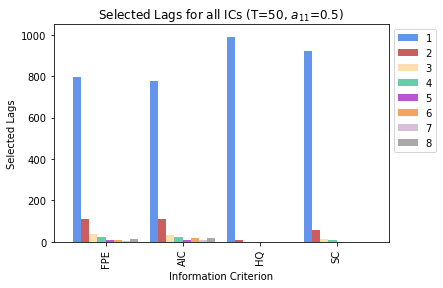

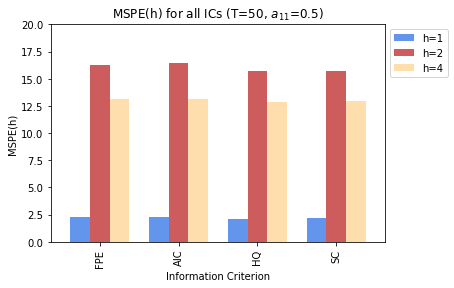

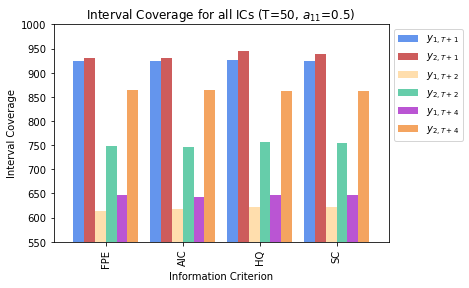

In [10]:
mc_a050_T1 = monte_carlo_var1(A1, sigma_u, T1+4)

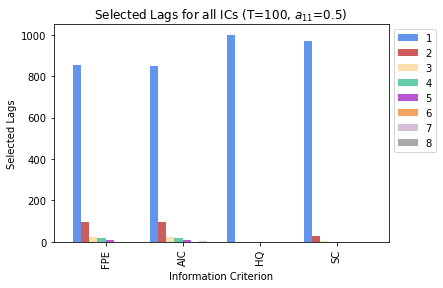

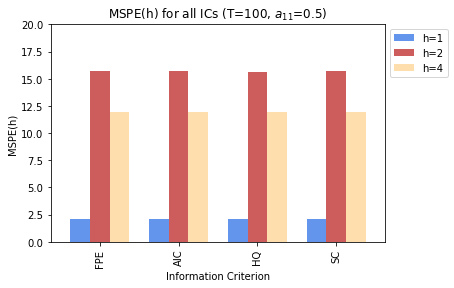

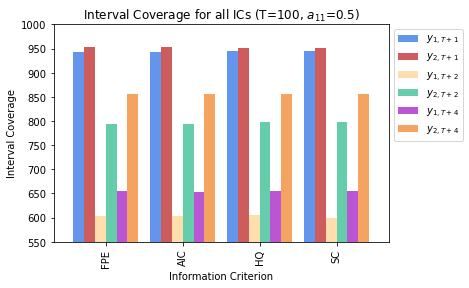

In [11]:
mc_a050_T2 = monte_carlo_var1(A1, sigma_u, T2+4)

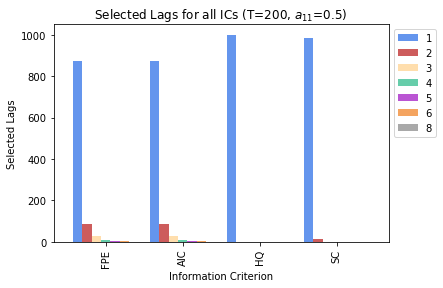

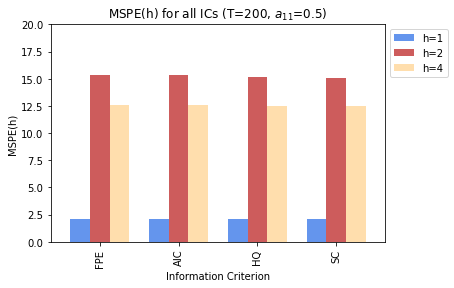

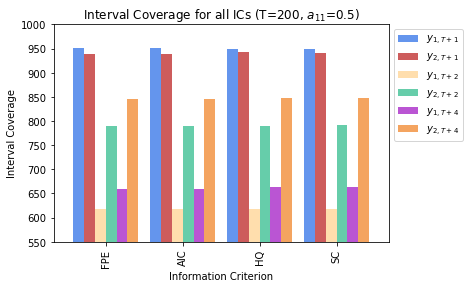

In [12]:
mc_a050_T3 = monte_carlo_var1(A1, sigma_u, T3+4)

Exercise 1(f)

In [13]:
a11 = 0.95
A1 = np.array([[a11, 0], 
              [0.5, 0.5]])

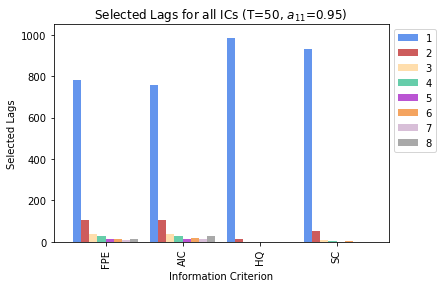

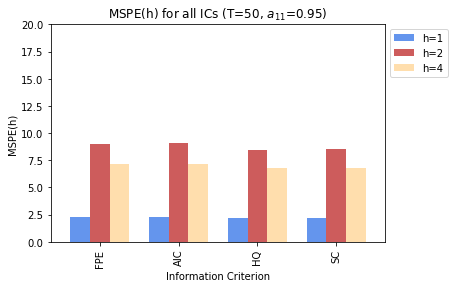

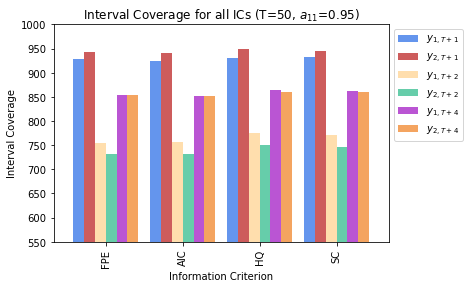

In [14]:
mc_a095_T1 = monte_carlo_var1(A1, sigma_u, T1+4)

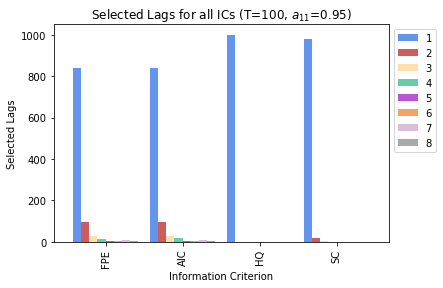

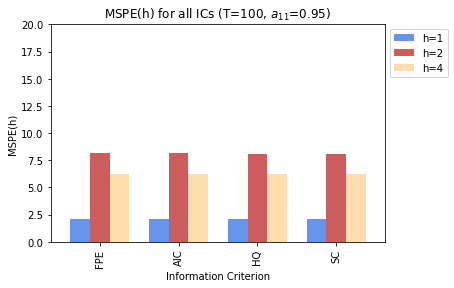

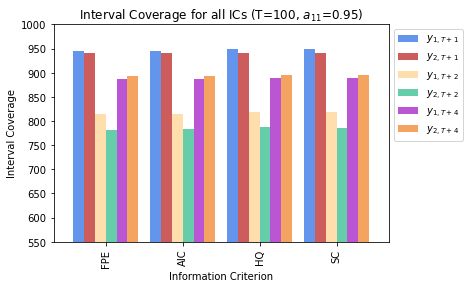

In [15]:
mc_a095_T2 = monte_carlo_var1(A1, sigma_u, T2+4)

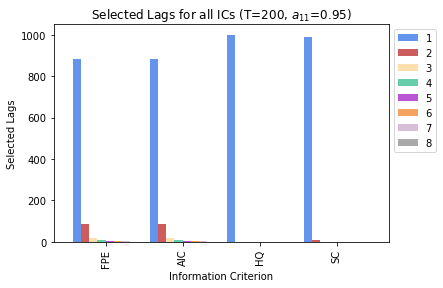

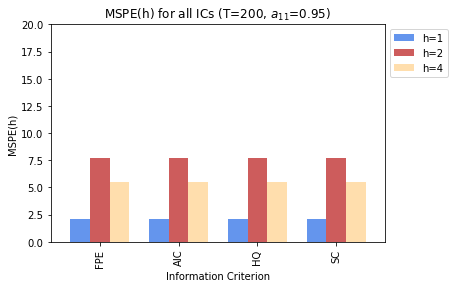

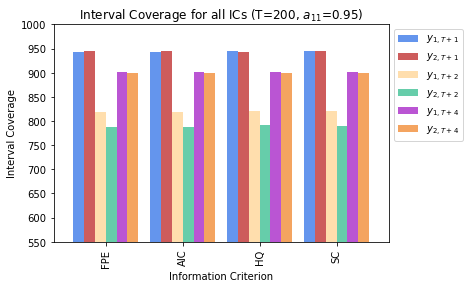

In [16]:
mc_a095_T3 = monte_carlo_var1(A1, sigma_u, T3+4)

## Exercise 2

In [158]:
usmacroex = pd.read_csv('usmacroex.csv', index_col=0, parse_dates=True)
usmacroex.head()

,GDPCTPI,UNRATE,DEXUSUK,FEDFUNDS
DATE,,,,
1960-01-01,16.527,5.4,.,3.84
1960-04-01,16.586,5.4,.,3.32
1960-07-01,16.658,5.5,.,2.60
1960-10-01,16.731,6.6,.,1.98
1961-01-01,16.751,6.9,.,2.02


Exercise 2(a)

In [160]:
# Data Transformation
usmacroex["GDPCTPI_log"] = np.log(usmacroex['GDPCTPI']) # log
usmacroex["D_GDPCTPI_log"] = usmacroex["GDPCTPI_log"].diff() # first differences
usmacroex["INF"] = usmacroex["D_GDPCTPI_log"] * 400 # annualize
usmacroex.head()

,GDPCTPI,UNRATE,DEXUSUK,FEDFUNDS,GDPCTPI_log,D_GDPCTPI_log,INF
DATE,,,,,,,
1960-01-01,16.527,5.4,.,3.84,2.804995,NaN,NaN
1960-04-01,16.586,5.4,.,3.32,2.808559,0.003564,1.425424
1960-07-01,16.658,5.5,.,2.60,2.812891,0.004332,1.732646
1960-10-01,16.731,6.6,.,1.98,2.817263,0.004373,1.749082
1961-01-01,16.751,6.9,.,2.02,2.818458,0.001195,0.477869


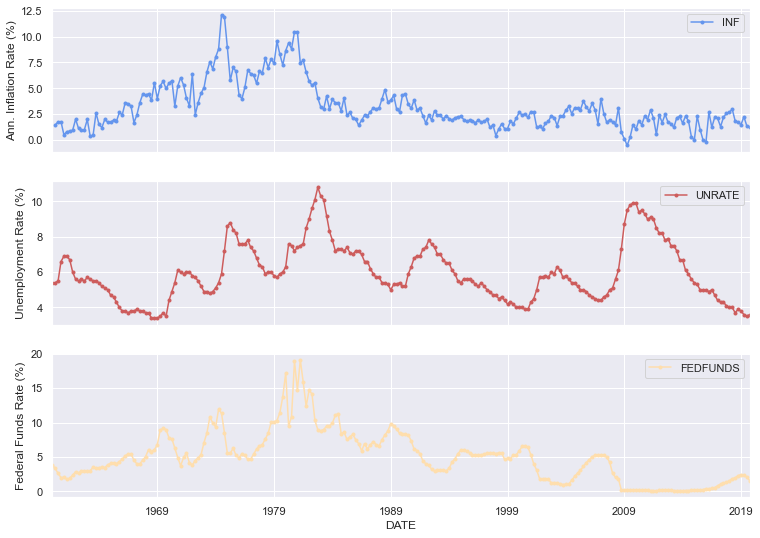

In [161]:
# Plot time series for INF, UNRATE, FEDFUNDS
sns.set(rc={'figure.figsize':(12.5, 4)}) # adjust figsize here

cols_plot = ['INF', 'UNRATE', 'FEDFUNDS']
axes = usmacroex[cols_plot][usmacroex.index < "2020-01-01"].plot(marker='.', alpha=1, linestyle='-', figsize=(12.5, 9), # ... and here
                                 subplots=True, color=['cornflowerblue', 'indianred', 'navajowhite'])
axes[0].set_ylabel('Ann. Inflation Rate (%)')
axes[1].set_ylabel('Unemployment Rate (%)')
axes[2].set_ylabel('Federal Funds Rate (%)')

plt.savefig(f'Graphs/2a_TS Plots INF_UNRATE_FEDFUNDS.png')


In [162]:
# Conduct ADF tests

# Ich habe jetzt mal bei allen eine Konstante ohne Trend genommen. Das ist eigentlich das einzige, das ökonomisch
# Sinn ergibt und es passt ja auch ganz gut zu den Plots

In [163]:
new_data = usmacroex[1:-11]  # TK: as INF is NaN for first observation and we just use data until 2019Q4

In [165]:
# ADF test INF --> not I(0)
adf_INF = adfuller(new_data['INF'],  autolag='AIC', maxlag=8, regression='c', regresults=True)
print('ADF Statistic: %f' % adf_INF[0])
print('p-value: %f' % adf_INF[1])
print('Critical Values:')
for key, value in adf_INF[2].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.239548
p-value: 0.192206
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [166]:
# ADF test UNRATE --> I(0)
adf_UNRATE = adfuller(new_data['UNRATE'],  autolag='AIC', maxlag=8, regression='c', regresults=True)
print('ADF Statistic: %f' % adf_UNRATE[0])
print('p-value: %f' % adf_UNRATE[1])
print('Critical Values:')
for key, value in adf_UNRATE[2].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.574581
p-value: 0.098365
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [167]:
# ADF test FEDFUNDS --> not I(0)
adf_FEDFUNDS = adfuller(new_data['FEDFUNDS'],  autolag='AIC', maxlag=8, regression='c', regresults=True)
print('ADF Statistic: %f' % adf_FEDFUNDS[0])
print('p-value: %f' % adf_FEDFUNDS[1])
print('Critical Values:')
for key, value in adf_FEDFUNDS[2].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.823402
p-value: 0.368907
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [168]:
#################################
# man muss bei anderen UNRATE und FEDFUNDS auch erst ab 1: nehmen da INF dort ja NaN ist
# man muss auch UNRATE nochmal differenzieren da 5% Signifikanz level

In [169]:
# Taking first differences of INF and UNRATE and FEDFUNDS to get input for second ADF test
new_data["DINF"] = new_data["INF"].diff()
new_data["DFEDFUNDS"] = new_data["FEDFUNDS"].diff()
new_data["DUNRATE"] = new_data["UNRATE"].diff()

new_data = new_data[1:]

/var/folders/tp/b5qvtcb148s92bgb4r468t_c0000gn/T/ipykernel_24148/1599573812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["DINF"] = new_data["INF"].diff()
/var/folders/tp/b5qvtcb148s92bgb4r468t_c0000gn/T/ipykernel_24148/1599573812.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data["DFEDFUNDS"] = new_data["FEDFUNDS"].diff()
/var/folders/tp/b5qvtcb148s92bgb4r468t_c0000gn/T/ipykernel_24148/1599573812.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [170]:
# ADF test DINF --> I(0) --> hence, INF is I(1) 
adf_DINF = adfuller(new_data['DINF'],  autolag='AIC', maxlag=8, regression='c', regresults=True) 
print('ADF Statistic: %f' % adf_DINF[0])
print('p-value: %f' % adf_DINF[1])
print('Critical Values:')
for key, value in adf_DINF[2].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -14.766985
p-value: 0.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [171]:
# ADF test DFEDFUNDS --> I(0) --> hence, FEDFUNDS is I(1) 
adf_DFEDFUNDS = adfuller(new_data['DFEDFUNDS'],  autolag='AIC', maxlag=8, regression='c', regresults=True) # first value nan
print('ADF Statistic: %f' % adf_DFEDFUNDS[0])
print('p-value: %f' % adf_DFEDFUNDS[1])
print('Critical Values:')
for key, value in adf_DFEDFUNDS[2].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.622393
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


In [172]:
# ADF test DUNRATE --> I(0) --> hence, UNRATE is I(1) 
adf_DUNRATE = adfuller(new_data['DUNRATE'],  autolag='AIC', maxlag=8, regression='c', regresults=True) 
print('ADF Statistic: %f' % adf_DUNRATE[0])
print('p-value: %f' % adf_DUNRATE[1])
print('Critical Values:')
for key, value in adf_DUNRATE[2].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.940851
p-value: 0.000000
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


### Exercise 2(b)

[9 2]
AIC: Portmanteau test for autocorrelation: Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 34 is zero. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         245.8          261.0   0.163 225
-----------------------------------------
SC: Portmanteau test for autocorrelation: Portmanteau-test for residual autocorrelation. H_0: residual autocorrelation up to lag 34 is zero. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value  df
-----------------------------------------
         360.5          328.6   0.002 288
-----------------------------------------
AIC: Normality test: p-value = normality (skew and kurtosis) test. H_0: data generated by normally-distributed process. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
         426.3    

/Users/timkleinlein/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/Users/timkleinlein/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


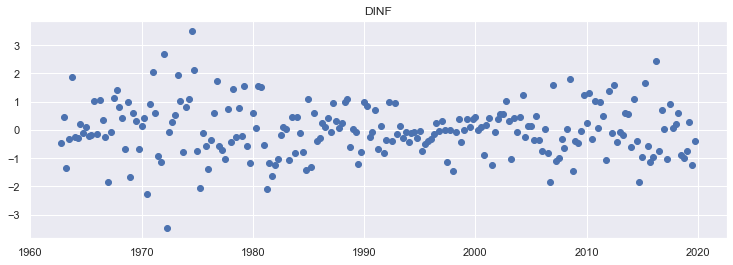

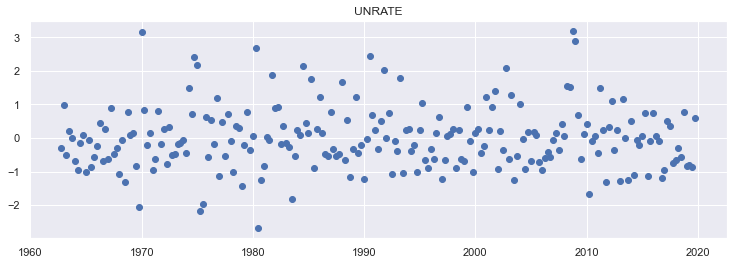

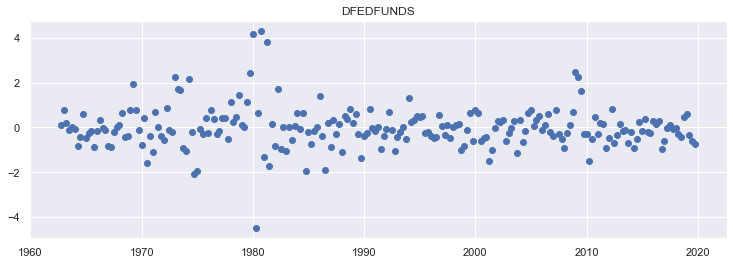

In [184]:
y = new_data[["DINF","UNRATE","DFEDFUNDS"]]
# retrieve lag-order suggested by AIC and SC (pmax = 12)
sgsted_lo = var_information_criteria(np.array(y).T, 12)[1:3]
print(sgsted_lo)

### estimate VARs with intercept
modelAIC = VAR(y)
varAIC = modelAIC.fit(sgsted_lo[0])
modelSC = VAR(y)
varSC = modelSC.fit(sgsted_lo[1])
#print(varAIC.summary(), "\n")
#portmanteau tests
print(f'AIC: Portmanteau test for autocorrelation: {varAIC.test_whiteness(34).summary()}')
print(f'SC: Portmanteau test for autocorrelation: {varSC.test_whiteness(34).summary()}')

#normality tests
print(f'AIC: Normality test: p-value = {varAIC.test_normality().summary()}')
print(f'SC: Normality test: p-value = {varSC.test_normality().summary()}')

#what do you conclude with respect to the adequacy of your models?
#both models have estimated errors which are not normally distributed. May indicate more general problems -> outliers, fat-tailed distribution

#standardize residuals
sigma_u = varAIC.sigma_u
P = np.linalg.cholesky(sigma_u)
#as mean_u is basically 0 for all k next lines could also be skipped
n = len(y)
mean_u = (1/n) * varAIC.resid.sum()
u_t_bar = varAIC.resid
u_t_bar['DINF'] = u_t_bar['DINF'] - mean_u[0]
u_t_bar['UNRATE'] = u_t_bar['UNRATE'] - mean_u[1]
u_t_bar['DFEDFUNDS'] = u_t_bar['DFEDFUNDS'] - mean_u[2]
std_resid = inv(P)@np.array(u_t_bar).T

#plot standardized residuals
for ind, col in enumerate(y.columns):
    plt.scatter(varAIC.resid.index,std_resid[ind,:])
    plt.title(col)
    plt.show()

# explanation: 
# extreme residuals due to exogenous shocks: 1970s energy crisis (DINF); 
# financial crisis 2008 (UNRATE (and also FEDFUNDS?)); early 80s recession (all of them)

# Which model would you prefer?
preferred_model = varAIC

In [78]:
"""
import statsmodels as sm
model = VAR(y)
results = model.select_order(12)
results.selected_orders
"""

'\nimport statsmodels as sm\nmodel = VAR(y)\nresults = model.select_order(12)\nresults.selected_orders\n'

In [47]:
### MUSS NOCH DRINGEND ÜBERARBEITET WERDEN / außerdem noch nicht vollständig

# combine vars
#y = pd.array([[usmacroex["DINF"], usmacroex["UNRATE"], usmacroex["DFEDFUNDS"]]]).T.reshape(251, 3)[2:,:] # dropping first two rows bc of diffs (i.e. are nan)

# retrieve lag-order suggested by AIC and SC (pmax = 12)
sgsted_lo = var_information_criteria(np.array(usmacroex[["DINF", "UNRATE", "DFEDFUNDS"]][usmacroex.index < "2020-01-01"].dropna()).T, 12)[1:3]
print(sgsted_lo)
### estimate VARs with intercept
### AIC
# BAIC, tratsAIC, covmatAIC = kdimvar(y, sgsted_lo[0], intercept=True)
model = VAR(usmacroex[["DINF", "UNRATE", "DFEDFUNDS"]][usmacroex.index < "2020-01-01"].dropna())
varAIC = model.fit(sgsted_lo[0])
#print(varAIC.summary(), "\n")

# do portmanteau test ### CHOOSING 34??? lags.. does this make sense?? taken from CT PS1 Ex1 f

print(varAIC.test_whiteness(34).summary(), "\n")
#print(varAIC.test_whiteness(34, adjusted=True).summary(), "\n") 
# 239 Quartale ist nicht so ein kleines Sample oder? Deshalb wahrscheinlich eher unadjusted? Ergebnisse wirken auch sinnvoller.

# normality tests
print(varAIC.test_normality(), "\n\n\n")

### SC
# BSC, tratsSC, covmatSC = kdimvar(y, sgsted_lo[1], intercept=True)
model = VAR(usmacroex[["DINF", "UNRATE", "DFEDFUNDS"]][usmacroex.index < "2020-01-01"].dropna())
varSC = model.fit(sgsted_lo[1])
#print(varSC.summary(), "\n")

print(varSC.test_whiteness(34).summary(), "\n")
#print(varSC.test_whiteness(34, adjusted=True).summary(), "\n")
print(varSC.test_normality(), "\n\n\n")
# residuals not normally distributed

#what do you conclude with respect to the adequacy of your models?

# plot standardized residuals of the model selected by AIC to explain your normality test results.


# zur standardisierung jeweils durch entsprechenden Wert von varAIC.stderr_dt teilen?
std_res = pd.DataFrame()
std_res['DINF'] = varAIC.resid['DINF'].div(varAIC.stderr_dt[0][0])
std_res['UNRATE'] = varAIC.resid['UNRATE'].div(varAIC.stderr_dt[0][1])
std_res['DFEDFUNDS'] = varAIC.resid['DFEDFUNDS'].div(varAIC.stderr_dt[0][2])

std_res.plot(subplots=True, layout=(3,1), title = 'Standardized residuals')

# explanation: 
# extreme residuals due to exogenous shocks: 1970s energy crisis (DINF); 
# financial crisis 2008 (UNRATE (and also FEDFUNDS?)); early 80s recession (all of them)

# Which model would you prefer?

# tbd
preferred_model = varAIC

### does this make sense?? taken from CT PS1 Ex1 e


KeyError: "['DINF', 'DFEDFUNDS'] not in index"

### Exercise 2(c)
Use your preferred VAR from 2b) and check whether the federal funds rate Grangercauses the remaining variables. Also test whether the inflation rate Granger-causes the other variables in the system. Use a significance level of 1%. Interpret your results.

In [29]:
print(preferred_model.test_causality(["DINF", "UNRATE"], "DFEDFUNDS", kind='f', signif=0.01), "\n")
print(preferred_model.test_causality(["UNRATE", "DFEDFUNDS"], "DINF", kind='f', signif=0.01))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: DFEDFUNDS does not Granger-cause [DINF, UNRATE]: reject at 1% significance level. Test statistic: 2.568, critical value: 1.964>, p-value: 0.000> 

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: DINF does not Granger-cause [UNRATE, DFEDFUNDS]: fail to reject at 1% significance level. Test statistic: 1.741, critical value: 1.964>, p-value: 0.029>


### Exercise 2(d)
Provide the estimated residual correlation matrix ˆRu of your preferred model. Given the results, explain why using forecast error impulse responses in this system may be misleading.

In [30]:
print(preferred_model.resid_corr)

[[ 1.         -0.10272203  0.15820679]
 [-0.10272203  1.         -0.38301791]
 [ 0.15820679 -0.38301791  1.        ]]


### Exercise 2(e)
Using the preferred model from 2b), compute and plot orthogonalized impulses responses. Make sure that you report responses of the level of inflation and the level of the federal funds rate. Use h = 24 and confidence intervals with a nominal coverage of 90%. Describe and interpret your results.

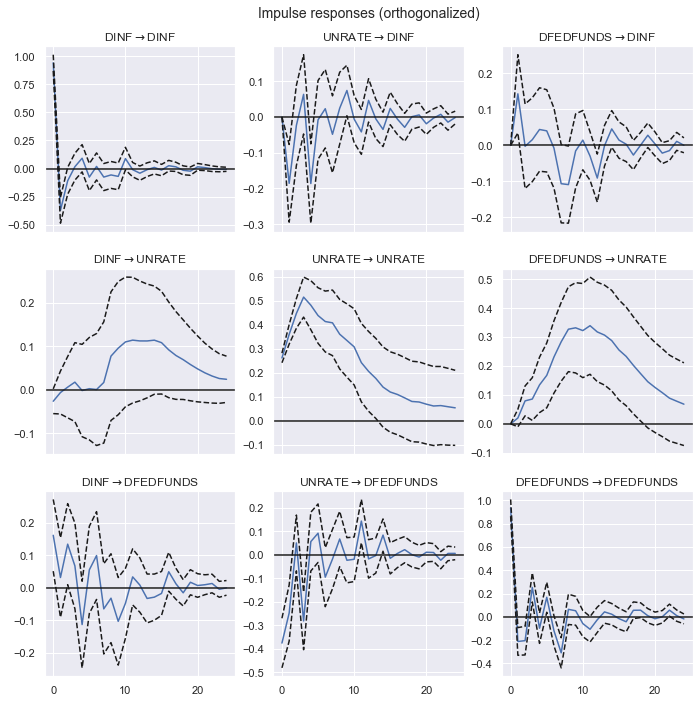

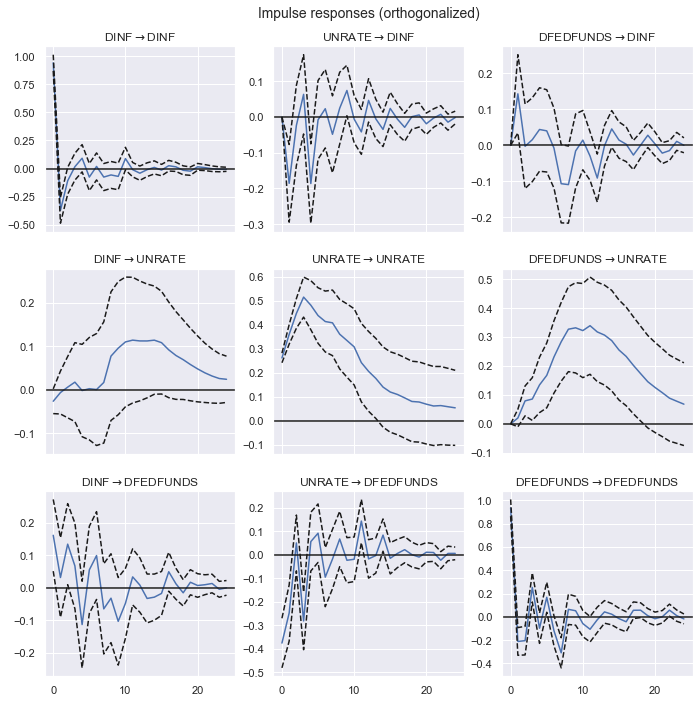

In [31]:
h = 24
irf = preferred_model.irf(h)

irf.plot(orth=True,signif=0.1)

# Note the plot function is flexible and can plot only variables of interest if so desired:
# irf.plot(impulse='realgdp')

## NOTE (from documentation+lecture): Orthogonalization is done using the Cholesky decomposition of the estimated error covariance matrix and hence interpretations may change depending on variable ordering.

### Exercise 2(f)
Based on your VAR model, perform a forecast error variance decomposition of the inflation, unemployment and federal funds rate. Comment on the relative importance of the monetary policy shock.

In [32]:
fevd = preferred_model.fevd(24) # 24 correct here??
fevd.summary()

FEVD for DINF
          DINF    UNRATE  DFEDFUNDS
0     1.000000  0.000000   0.000000
1     0.948794  0.032070   0.019136
2     0.948848  0.032224   0.018927
3     0.945159  0.035764   0.019077
4     0.915117  0.064848   0.020035
5     0.914180  0.064491   0.021329
6     0.913736  0.064902   0.021362
7     0.903387  0.065840   0.030773
8     0.894048  0.065478   0.040474
9     0.890156  0.069523   0.040320
10    0.890703  0.069075   0.040222
11    0.888758  0.070367   0.040875
12    0.881263  0.071444   0.047292
13    0.881251  0.071460   0.047289
14    0.878869  0.072251   0.048880
15    0.878316  0.072663   0.049021
16    0.878350  0.072650   0.049000
17    0.877248  0.073228   0.049525
18    0.877268  0.073216   0.049516
19    0.876727  0.073163   0.050110
20    0.876485  0.073419   0.050096
21    0.876153  0.073393   0.050454
22    0.875960  0.073422   0.050618
23    0.875726  0.073571   0.050703

FEVD for UNRATE
          DINF    UNRATE  DFEDFUNDS
0     0.010552  0.989448   0.0000

### Exercise 2(h)
Repeat your analysis from 2e) using all variables in levels, i.e. redo your analysis with yt = (INFt,UNRATEt,FEDFUNDSt)′. Compare the results from the impulse response analysis to those in 2e).

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


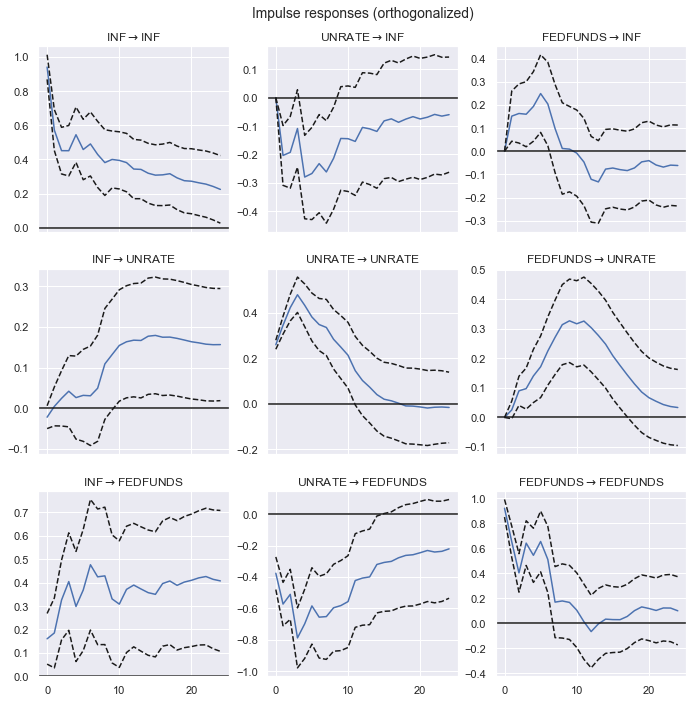

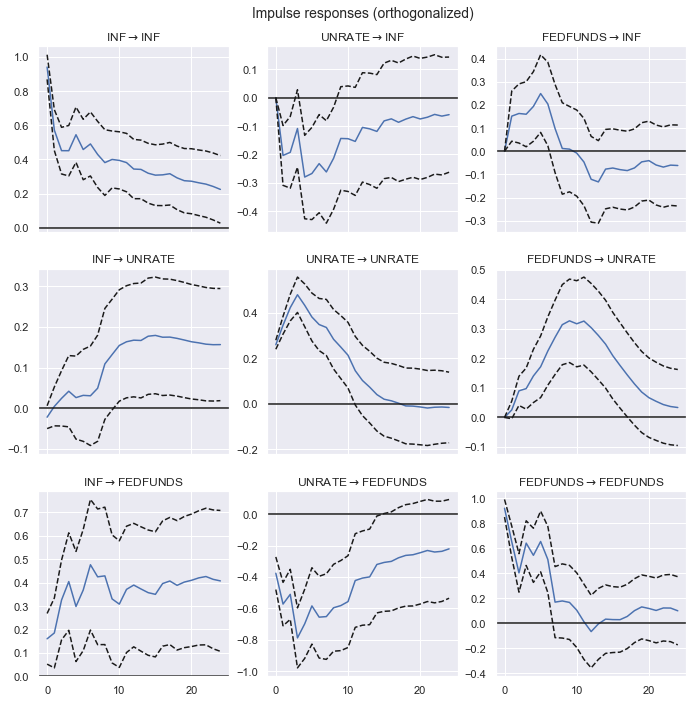

In [33]:
### estimate VAR with intercept
### AIC
model = VAR(usmacroex[["INF", "UNRATE", "FEDFUNDS"]][usmacroex.index < "2020-01-01"].dropna())
varAIClvl = model.fit(sgsted_lo[0]) ### ARE WE STILL USING THE SAME LAG-order?

h = 24
irf = varAIClvl.irf(h)

irf.plot(orth=True,signif=0.1)

### Exercise 2(i)
Now add the exchange rate as a fourth variables to the VAR, i.e. use yt = (ΔINFt,UNRATEt,ΔFEDFUNDSt,DEXUSUKt)′.
Compute orthogonalized IRFs to innovations in the federal funds rate and the exchange rate from a VAR(m), where m is selected by AIC. Report responses for INFt, UNRATEt, FEDFUNDSt, and DEXUSUKt.

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


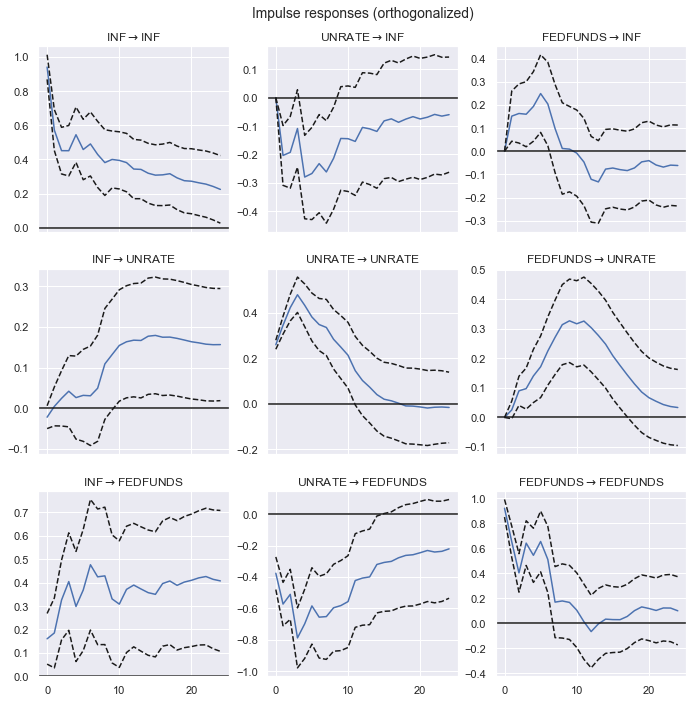

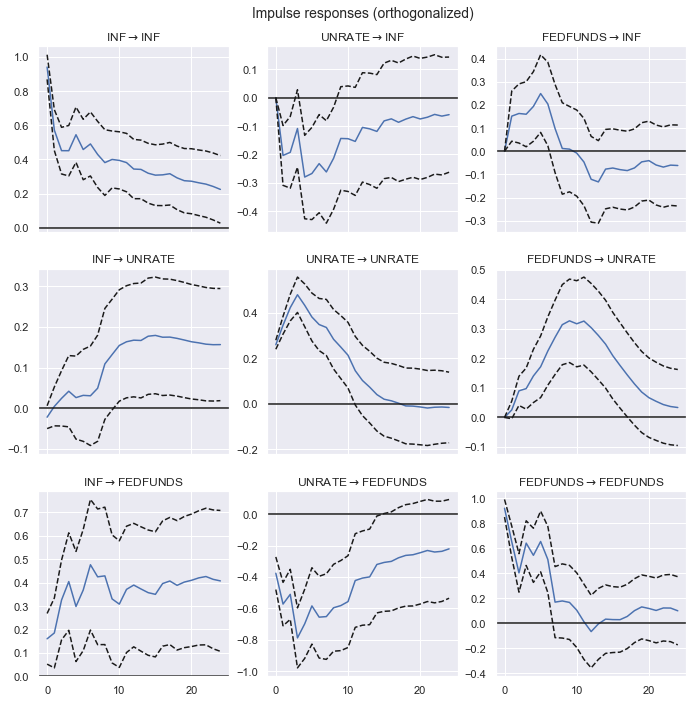

In [34]:
### estimate VAR with intercept
### AIC
usmacroex["DEXUSUK"] = pd.to_numeric(usmacroex["DEXUSUK"], errors="coerce")
model = VAR(usmacroex[["DINF", "UNRATE", "DFEDFUNDS", "DEXUSUK"]][usmacroex.index < "2020-01-01"].dropna())

m = var_information_criteria(np.array(usmacroex[["DINF", "UNRATE", "DFEDFUNDS", "DEXUSUK"]][usmacroex.index < "2020-01-01"].dropna()).T, 12)[1]

varAICdex = model.fit(m)

h = 24
irf = varAIClvl.irf(h)

irf.plot(orth=True,signif=0.1)

#### Exercise 2(i) i.
Describe and interpret the responses of the system variables to the ‘exchange rate’ shock. Do you find them economically plausible?



#### Exercise 2(i) ii.
Repeat the FEVD exercise on the VAR including DEXUSUKt. Does the relative importance of the monetary policy shock change? Describe any changes compared to 2f).


In [35]:
fevdAIClvl = varAIClvl.fevd(24) # 24 correct here??
fevdAIClvl.summary()

FEVD for INF
           INF    UNRATE  FEDFUNDS
0     1.000000  0.000000  0.000000
1     0.949424  0.032582  0.017994
2     0.916879  0.051033  0.032088
3     0.907146  0.050790  0.042065
4     0.871824  0.076980  0.051195
5     0.836554  0.094768  0.068678
6     0.822387  0.102525  0.075088
7     0.812279  0.115846  0.071876
8     0.809269  0.122944  0.067787
9     0.813162  0.122516  0.064322
10    0.816403  0.122338  0.061260
11    0.817827  0.123075  0.059097
12    0.817960  0.121405  0.060635
13    0.817236  0.120041  0.062723
14    0.817742  0.119935  0.062323
15    0.819456  0.118543  0.062001
16    0.821146  0.116940  0.061914
17    0.822446  0.115667  0.061887
18    0.823759  0.114517  0.061724
19    0.825422  0.113478  0.061100
20    0.826850  0.112737  0.060413
21    0.827894  0.111928  0.060178
22    0.828786  0.110984  0.060230
23    0.829479  0.110369  0.060152

FEVD for UNRATE
           INF    UNRATE  FEDFUNDS
0     0.007511  0.992489  0.000000
1     0.002797  0.993708 

#### Exercise 2(i) iii.
Are there changes in the responses to a ‘monetary policy shock’ compared to your results from 2e)? Reestimate the 4 variable model over a sample ending in 2007Q4. Are there changes in the response to a monetary policy shock? What do you conclude?

C:\Users\HP\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'


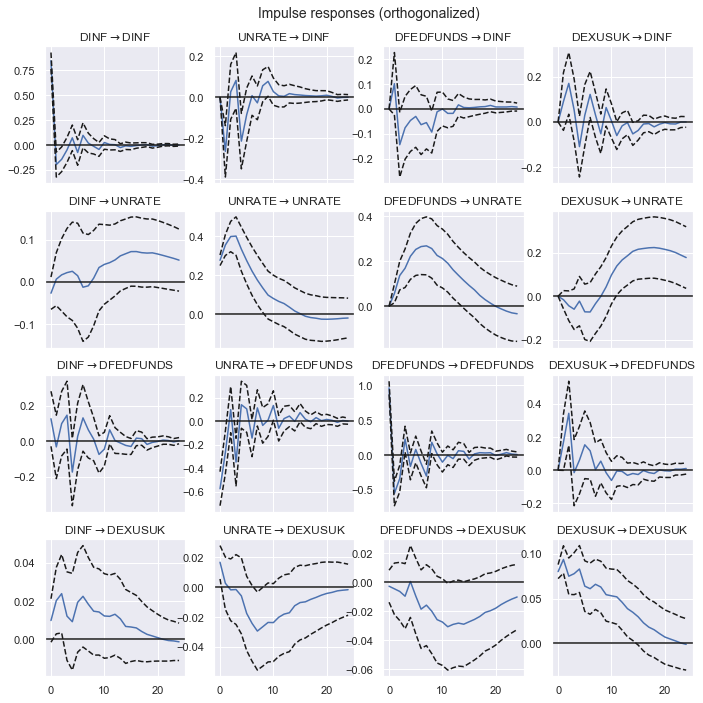

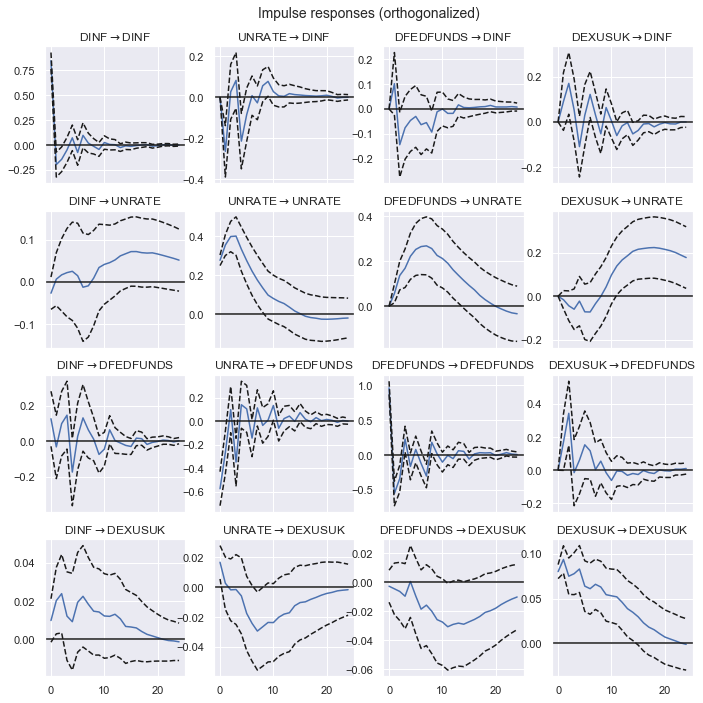

In [36]:
### estimate VAR with intercept
### AIC
model = VAR(usmacroex[["DINF", "UNRATE", "DFEDFUNDS", "DEXUSUK"]][usmacroex.index < "2008-01-01"].dropna())

m = var_information_criteria(np.array(usmacroex[["DINF", "UNRATE", "DFEDFUNDS", "DEXUSUK"]][usmacroex.index < "2008-01-01"].dropna()).T, 12)[1]

varAICdexshort = model.fit(m)

h = 24
irf = varAICdexshort.irf(h)

irf.plot(orth=True,signif=0.1)

Junk

In [37]:
def var_information_criteria_given(y_t: np.array, sigma_u: np.array, p_max: int):
    """A function to calculate the 4 information criteria (FPE, AIC, HQ, SC) for a VAR process with maxlag = pmax.
       Assumes the covariance matrix Σ_u is known. Return the chosen lag order.

    Args:
        y_t (np.array): K x T matrix of observations on y_t
        sigma_u (np.array): covariance matrix Σ_u
        p_max (int): maximum number of lags included in the model

    Returns:
        int: The chosen information criterion based on the mode of the suggestions of the 4 criteria. 
             In case of a draw, the higher one is selected.
    """
    
    # arrays to store IC values
    FPE, AIC, HQ, SC = np.zeros(p_max), np.zeros(p_max), np.zeros(p_max), np.zeros(p_max)

    # get T and K from the shape of the input
    K = y_t.shape[0]
    T = y_t.shape[1]
    
    # calculate information criteria for lags 
    for m in range(1, p_max+1):
        
        # calculate ICs for given lag m (2.107 - 2.114)
        FPE[m-1] = (((T + K*m + 1) / (T - K*m - 1)) ** K) * det(sigma_u)
        AIC[m-1] = np.log(det(sigma_u)) + ((2*(K**2)*m)/T)
        HQ[m-1] = np.log(det(sigma_u)) + ((2*np.log(np.log(T)))/T) * (K**2)*m
        SC[m-1] = np.log(det(sigma_u)) + (np.log(T)/T) * (K**2)*m
    
    # store all in one array and select the lowest values    
    criteria_all_lags = np.array([FPE, AIC, SC, HQ])
    lag_orders_selected = np.argmin(criteria_all_lags, axis=1)+1
    
    
    return p_hat

In [38]:
def var_information_criteria(y_t: np.array, p_max: int):
    """A function to calculate the 4 information criteria (FPE, AIC, HQ, SC) for a VAR process with maxlag = pmax.
       Assumes model has an intercept and at least one lag. Returns the chosen lag order.
       
       ### Right now also has built-in as controls ###

    Args:
        y_t (np.array): K x (T + p_max) matrix of observations on y_t
        p_max (int): maximum number of lags included in the model

    Returns:
        int: The chosen information criterion based on the mode of the suggestions of the 4 criteria. 
             In case of a draw, the higher one is selected.
    """
    
    # arrays to store IC values
    FPE, AIC, HQ, SC = np.zeros(p_max), np.zeros(p_max), np.zeros(p_max), np.zeros(p_max)
    b_FPE, b_AIC, b_HQ, b_SC = np.zeros(p_max), np.zeros(p_max), np.zeros(p_max), np.zeros(p_max) # built-in for control

    # get T and K from the shape of the input
    K = y_t.shape[0]
    T = y_t.shape[1] - p_max # lags needed for estimation
    
    # calculate information criteria for lags m
    for m in range(1, p_max+1):
        
        # built-in test for control
        model = VAR(y_t[:, p_max-m:].T)
        
        # estimate sigma_u_tilde with MLE (2.55 - 2.56)
        Z = Z_matrix(y_t[:, p_max-m:].T,  m, c=1) # take m lags for estimation
        B_tilde = y_t[:, p_max:] @ Z.T @ inv(Z@Z.T)
        sigma_tilde_m = (1/T)*(y_t[:, p_max:] - B_tilde@Z)@(y_t[:, p_max:] - B_tilde@Z).T
        
        # calculate ICs for given lag m (2.107 - 2.114)
        det_sigma_tilde_m = det(sigma_tilde_m)
        FPE[m-1] = (((T + K*m + 1) / (T - K*m - 1)) ** K) * det_sigma_tilde_m
        AIC[m-1] = np.log(det_sigma_tilde_m) + ((2*(K**2)*m)/T)
        HQ[m-1] = np.log(det_sigma_tilde_m) + ((2*np.log(np.log(T)))/T) * (K**2)*m
        SC[m-1] = np.log(det_sigma_tilde_m) + (np.log(T)/T) * (K**2)*m
        
        # built in for control
        result = model.fit(m)
        b_FPE[m-1] = result.fpe
        b_AIC[m-1] = result.aic
        b_HQ[m-1] = result.hqic
        b_SC[m-1] = result.bic
    
    # store all in one array and select the lowest values    
    criteria_all_lags = np.array([FPE, AIC, SC, HQ])
    lag_orders_selected = np.argmin(criteria_all_lags, axis=1)+1
    infoC = np.amin(criteria_all_lags, axis=1)
    
    # built-in for control 
    b_criteria_all_lags = np.array([b_FPE, b_AIC, b_SC, b_HQ])
    b_lag_orders_selected = np.argmin(b_criteria_all_lags, axis=1)+1
    b_infoC = np.amin(criteria_all_lags, axis=1)

    
    """
    Note: Liew (2004) (https://ssrn.com/abstract=885505):
    "The most interesting finding of this study is that Akaike’s information criterion (AIC) and 
    final prediction error (FPE) are superior than the other criteria under study in the case of 
    small sample (60 observations and below), in the manners that they minimize the chance of under
    estimation while maximizing the chance of recovering the true lag length."  
    """
    
    return p_hat, lag_orders_selected